In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
sns.set_theme()

In [ ]:
import os
#add .. to path via os
os.chdir('..')
print(os.getcwd())

c:\Polimi\Master\2Sem\NLP-Project


In [ ]:
class BiLSTM_NER(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_outcomes):
        super(BiLSTM_NER, self).__init__()
        # Bidirectional LSTM; we set batch_first=True to have input like [batch, seq_len, embedding_dim]
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=False, batch_first=True)
        # Fully connected layer to map hidden state coming from LSTM to output labels
        # (the hidden state is a concatenation of two LSTM outputs since it is bidirectional)
        self.fc = nn.Linear(hidden_dim, num_outcomes)

    def forward(self, x):
        # x: [batch_size, seq_len]
        lstm_out, _ = self.lstm.forward(x)   # lstm_out: [batch_size, seq_len, hidden_dim*2]
        logits = self.fc(lstm_out[:, -1, :])        # logits: [batch_size, num_tags]
        probabs = torch.nn.functional.softmax(logits, dim=-1)  # probabs: [batch_size, num_tags]
        return probabs, logits
    
model:BiLSTM_NER = BiLSTM_NER(100, 128, 3)
# print(model.state_dict().keys())
state_dict = torch.load("./model_weights/bilstm_ner_model.pth", weights_only=True, map_location=torch.device('cpu'))
# print(state_dict.keys())
model.load_state_dict(state_dict)
model.eval()

BiLSTM_NER(
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
from nlpChess.dataset.ChessDataset import ChessDataset
from nlpChess.utils.DatasetLoader import loadDataset

In [ ]:
#Load the dataset
ds = loadDataset()
df = ds['validation'].to_pandas()
df.head()

,Moves,Termination,Result,pieces,captures,checks,next_moves,termination_seqs,result_seqs,__index_level_0__
0,"[c2c4, c7c5, g2g3, g8f6, f1g2, d7d6, g1f3, g7g...",CHECKMATE,1-0,"[p, p, p, n, b, p, n, p, p, b, k, p, n, p, b, ...","[, , , , , , , , , , , p, p, , , , , , , , , ,...","[False, False, False, False, False, False, Fal...","[c7c5, g2g3, g8f6, f1g2, d7d6, g1f3, g7g6, d2d...","[CHECKMATE, CHECKMATE, CHECKMATE, CHECKMATE, C...","[1-0, 1-0, 1-0, 1-0, 1-0, 1-0, 1-0, 1-0, 1-0, ...",63137
1,"[d2d4, g7g6, e2e4, f8g7, b1c3, c7c5, d4d5, d7d...",CHECKMATE,1-0,"[p, p, p, b, n, p, p, p, n, n, p, k, b, n, p, ...","[, , , , , , , , , , , , , , , , , , n, n, , ,...","[False, False, False, False, False, False, Fal...","[g7g6, e2e4, f8g7, b1c3, c7c5, d4d5, d7d6, g1f...","[CHECKMATE, CHECKMATE, CHECKMATE, CHECKMATE, C...","[1-0, 1-0, 1-0, 1-0, 1-0, 1-0, 1-0, 1-0, 1-0, ...",75080
2,"[d2d4, c7c6, c2c4, d7d5, g1f3, g8f6, b1c3, a7a...",CHECKMATE,0-1,"[p, p, p, p, n, n, n, p, p, p, p, p, b, n, k, ...","[, , , , , , , , , , , , , , , p, p, p, p, , ,...","[False, False, False, False, False, False, Fal...","[c7c6, c2c4, d7d5, g1f3, g8f6, b1c3, a7a6, a2a...","[CHECKMATE, CHECKMATE, CHECKMATE, CHECKMATE, C...","[0-1, 0-1, 0-1, 0-1, 0-1, 0-1, 0-1, 0-1, 0-1, ...",86128
3,"[e2e4, e7e5, g1f3, b8c6, f1b5, a7a6, b5c6, d7c...",FIVEFOLD_REPETITION,1/2-1/2,"[p, p, n, n, b, p, b, p, k, q, p, n, p, p, p, ...","[, , , , , , n, b, , , , , , p, , p, p, , , , ...","[False, False, False, False, False, False, Fal...","[e7e5, g1f3, b8c6, f1b5, a7a6, b5c6, d7c6, e1g...","[FIVEFOLD_REPETITION, FIVEFOLD_REPETITION, FIV...","[1/2-1/2, 1/2-1/2, 1/2-1/2, 1/2-1/2, 1/2-1/2, ...",73626
4,"[g1f3, d7d5, g2g3, g8f6, f1g2, c7c6, e1g1, c8f...",CHECKMATE,0-1,"[n, p, p, n, b, p, k, b, p, p, b, p, p, b, p, ...","[, , , , , , , , , , , , , , , , , , , , , , b...","[False, False, False, False, False, False, Fal...","[d7d5, g2g3, g8f6, f1g2, c7c6, e1g1, c8f5, b2b...","[CHECKMATE, CHECKMATE, CHECKMATE, CHECKMATE, C...","[0-1, 0-1, 0-1, 0-1, 0-1, 0-1, 0-1, 0-1, 0-1, ...",44173


In [ ]:
moves = df['Moves']
moves.head()

0    [c2c4, c7c5, g2g3, g8f6, f1g2, d7d6, g1f3, g7g...
1    [d2d4, g7g6, e2e4, f8g7, b1c3, c7c5, d4d5, d7d...
2    [d2d4, c7c6, c2c4, d7d5, g1f3, g8f6, b1c3, a7a...
3    [e2e4, e7e5, g1f3, b8c6, f1b5, a7a6, b5c6, d7c...
4    [g1f3, d7d5, g2g3, g8f6, f1g2, c7c6, e1g1, c8f...
Name: Moves, dtype: object

In [ ]:
from nlpChess.models import Word2VecChess

In [ ]:
import pickle
GET_EMBEDDINGS = True

if GET_EMBEDDINGS:
    outcomes = []
    hs = []
    lstmEmbeddings = []

    for d in tqdm.tqdm(moves):
        movesEmbeddings = torch.Tensor(Word2VecChess.wv[d])

        # Get the model output
        with torch.no_grad():
            lstmOutput, (h, c) = model.lstm(movesEmbeddings.unsqueeze(0))  # Add batch dimension

        # Get the last hidden state
        outcomes.append(lstmOutput[:, -1, :].cpu().numpy())
        hs.append(h.cpu().numpy())
        lstmEmbeddings.append(c.cpu().numpy())

    #Save the embeddings
    with open('embeddings.pkl', 'wb') as f:
        pickle.dump({'outcomes': outcomes, 'hs': hs, 'cs': lstmEmbeddings}, f)

100%|██████████| 19999/19999 [00:41<00:00, 478.80it/s]


In [ ]:
#Load the embeddings
with open('embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [ ]:
lstmEmbeddings = torch.Tensor(embeddings['outcomes']).squeeze()
lstmEmbeddings.shape

torch.Size([19999, 128])

In [ ]:
matchOutcomes = df['Result']
matchOutcomes = np.array(matchOutcomes)
matchOutcomes.shape

(19999,)

In [ ]:
match_outcomes_lookup = {
    0: "0-1",
    1: "1/2-1/2",
    2: "1-0"
}
match_outcomes_lookup

{0: '0-1', 1: '1/2-1/2', 2: '1-0'}

In [ ]:
matchOutcomesLabels = matchOutcomes
matchOutcomesLabels = np.array(matchOutcomesLabels)
matchOutcomesLabels

array(['1-0', '1-0', '0-1', ..., '1/2-1/2', '1/2-1/2', '1/2-1/2'],
      dtype=object)

In [ ]:
matchTerminations = df['Termination']

In [ ]:
matchTerminationsLabels = matchTerminations
matchTerminationsLabels = np.array(matchTerminationsLabels)
matchTerminationsLabels

array(['CHECKMATE', 'CHECKMATE', 'CHECKMATE', ...,
       'INSUFFICIENT_MATERIAL', 'INSUFFICIENT_MATERIAL',
       'INSUFFICIENT_MATERIAL'], dtype=object)

In [ ]:
from matplotlib.lines import Line2D

matchTerminationColorsPalette = {
    'CHECKMATE': 'red',
    'INSUFFICIENT_MATERIAL': 'blue',
    'SEVENTYFIVE_MOVES': 'green',
    'FIVEFOLD_REPETITION': 'purple',
    'STALEMATE': 'orange'
}
legendElementTermination = [
    plt.Line2D([0], [0], marker='o', color='w', label=key, 
               markerfacecolor=value, markersize=10) 
    for key, value in matchTerminationColorsPalette.items()
]

matchTerminationColors = [matchTerminationColorsPalette[d] for d in tqdm.tqdm(matchTerminationsLabels)]
matchTerminationColors = np.array(matchTerminationColors)
matchTerminationColors


100%|██████████| 19999/19999 [00:00<00:00, 2951612.85it/s]


array(['red', 'red', 'red', ..., 'blue', 'blue', 'blue'], dtype='<U6')

In [ ]:
# Use a nicer color palette from seaborn
palette = sns.color_palette("Set1", n_colors=3)
labelColors = {
    '1-0': palette[0],
    '0-1': palette[1],
    '1/2-1/2': palette[2],
}

matchOutcomesColors = [labelColors[d] for d in tqdm.tqdm(matchOutcomesLabels)]
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8)
    for label, color in labelColors.items()
]
matchOutcomesColors


100%|██████████| 19999/19999 [00:00<00:00, 2594472.35it/s]


[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.8941176470588236, 0.10196

In [ ]:
matchOutcomes

array(['1-0', '1-0', '0-1', ..., '1/2-1/2', '1/2-1/2', '1/2-1/2'],
      dtype=object)

In [ ]:
lstmEmbeddings.shape

torch.Size([19999, 128])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=128)
cs_sampled_pca = pca.fit_transform(lstmEmbeddings)
cs_sampled_pca.shape

(19999, 128)

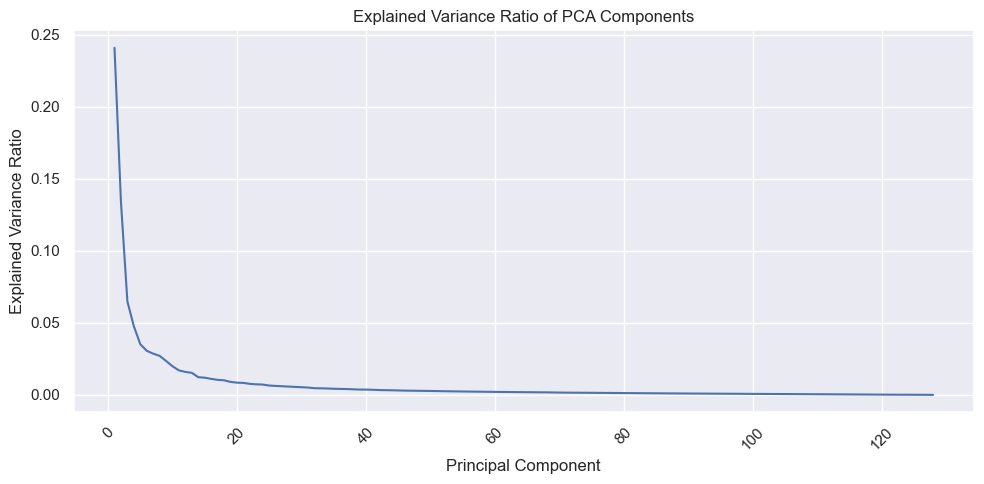

In [ ]:
#Plot the explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.title('Explained Variance Ratio of PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

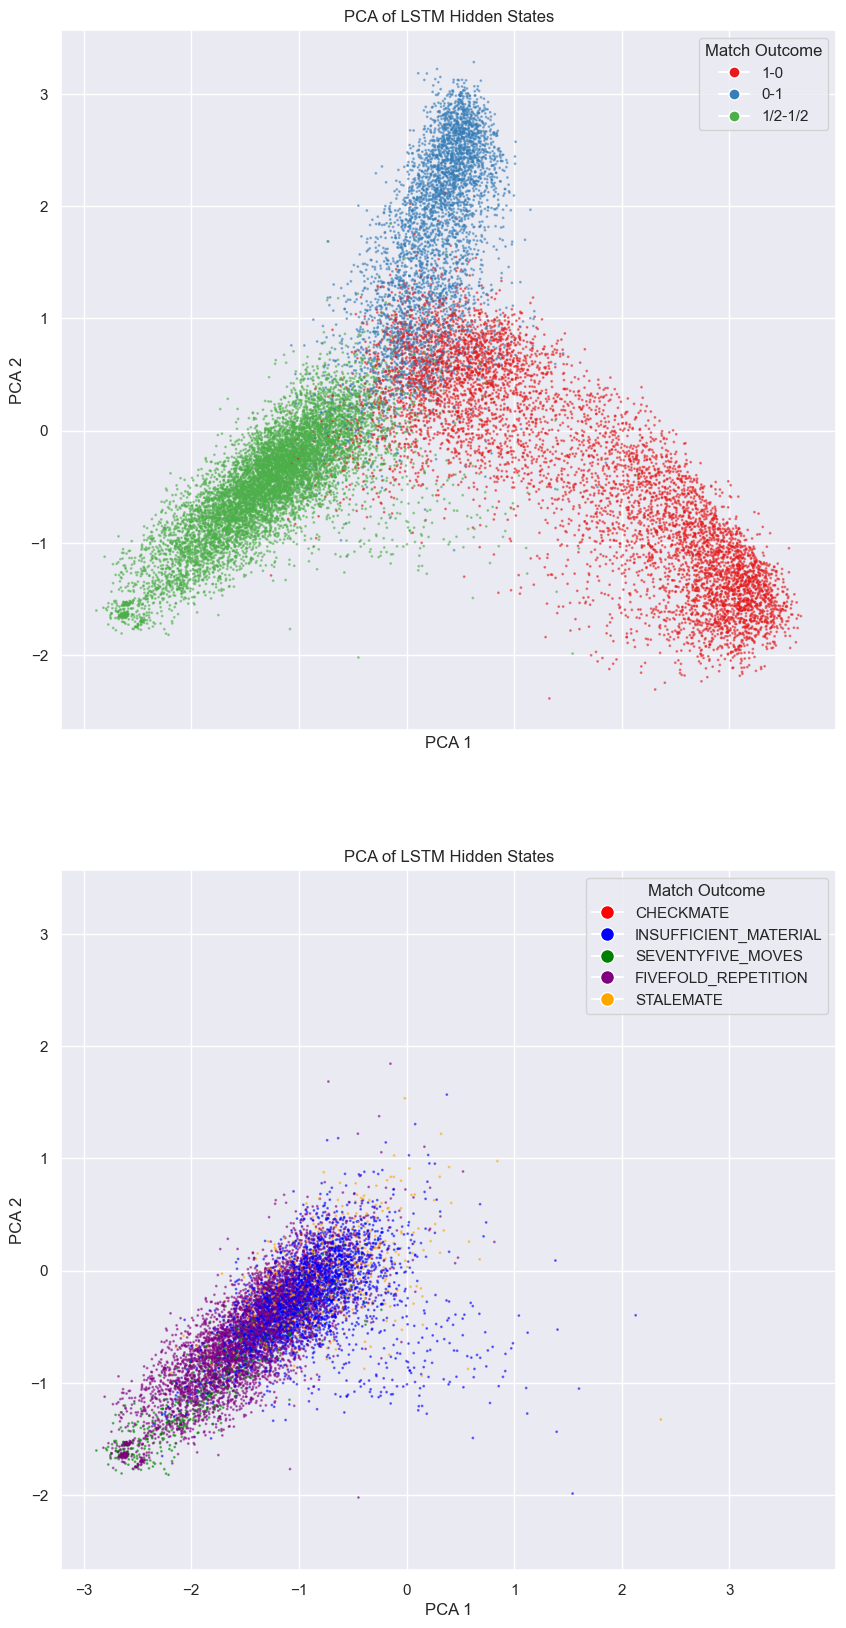

In [ ]:
# Plot the PCA
plt.figure(figsize=(10, 10))
fig, axes = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)
axes[0].scatter(cs_sampled_pca[:, 0], cs_sampled_pca[:, 1], alpha=0.5, s=1, c=matchOutcomesColors)
axes[0].legend(handles=legend_elements, title="Match Outcome")
axes[0].set_title("PCA of LSTM Hidden States")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

cs_sampled_noCkeckmates = cs_sampled_pca[matchTerminationsLabels != 'CHECKMATE']
matchTerminationColors_noCheckmates = matchTerminationColors[matchTerminationsLabels != 'CHECKMATE']
axes[1].scatter(cs_sampled_noCkeckmates[:, 0], cs_sampled_noCkeckmates[:, 1], alpha=0.5, s=1, c=matchTerminationColors_noCheckmates)
axes[1].legend(handles=legendElementTermination, title="Match Outcome")
axes[1].set_title("PCA of LSTM Hidden States")
axes[1].set_xlabel("PCA 1")
axes[1].set_ylabel("PCA 2")
plt.show()

In [ ]:
#Perform tsne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, n_jobs=8, verbose=1, metric="cosine")
cs_sampled_tsne = tsne.fit_transform(lstmEmbeddings)
cs_sampled_tsne.shape

  0%|          | 0/19999 [02:45<?, ?it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19999 samples in 0.001s...
[t-SNE] Computed neighbors for 19999 samples in 12.802s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19999
[t-SNE] Computed conditional probabilities for sample 2000 / 19999
[t-SNE] Computed conditional probabilities for sample 3000 / 19999
[t-SNE] Computed conditional probabilities for sample 4000 / 19999
[t-SNE] Computed conditional probabilities for sample 5000 / 19999
[t-SNE] Computed conditional probabilities for sample 6000 / 19999
[t-SNE] Computed conditional probabilities for sample 7000 / 19999
[t-SNE] Computed conditional probabilities for sample 8000 / 19999
[t-SNE] Computed conditional probabilities for sample 9000 / 19999
[t-SNE] Computed conditional probabilities for sample 10000 / 19999
[t-SNE] Computed conditional probabilities for sample 11000 / 19999
[t-SNE] Computed conditional probabilities for sample 12000 / 19999
[t-SNE] Computed conditional probabilities for sa

(19999, 2)

<Figure size 1000x1000 with 0 Axes>

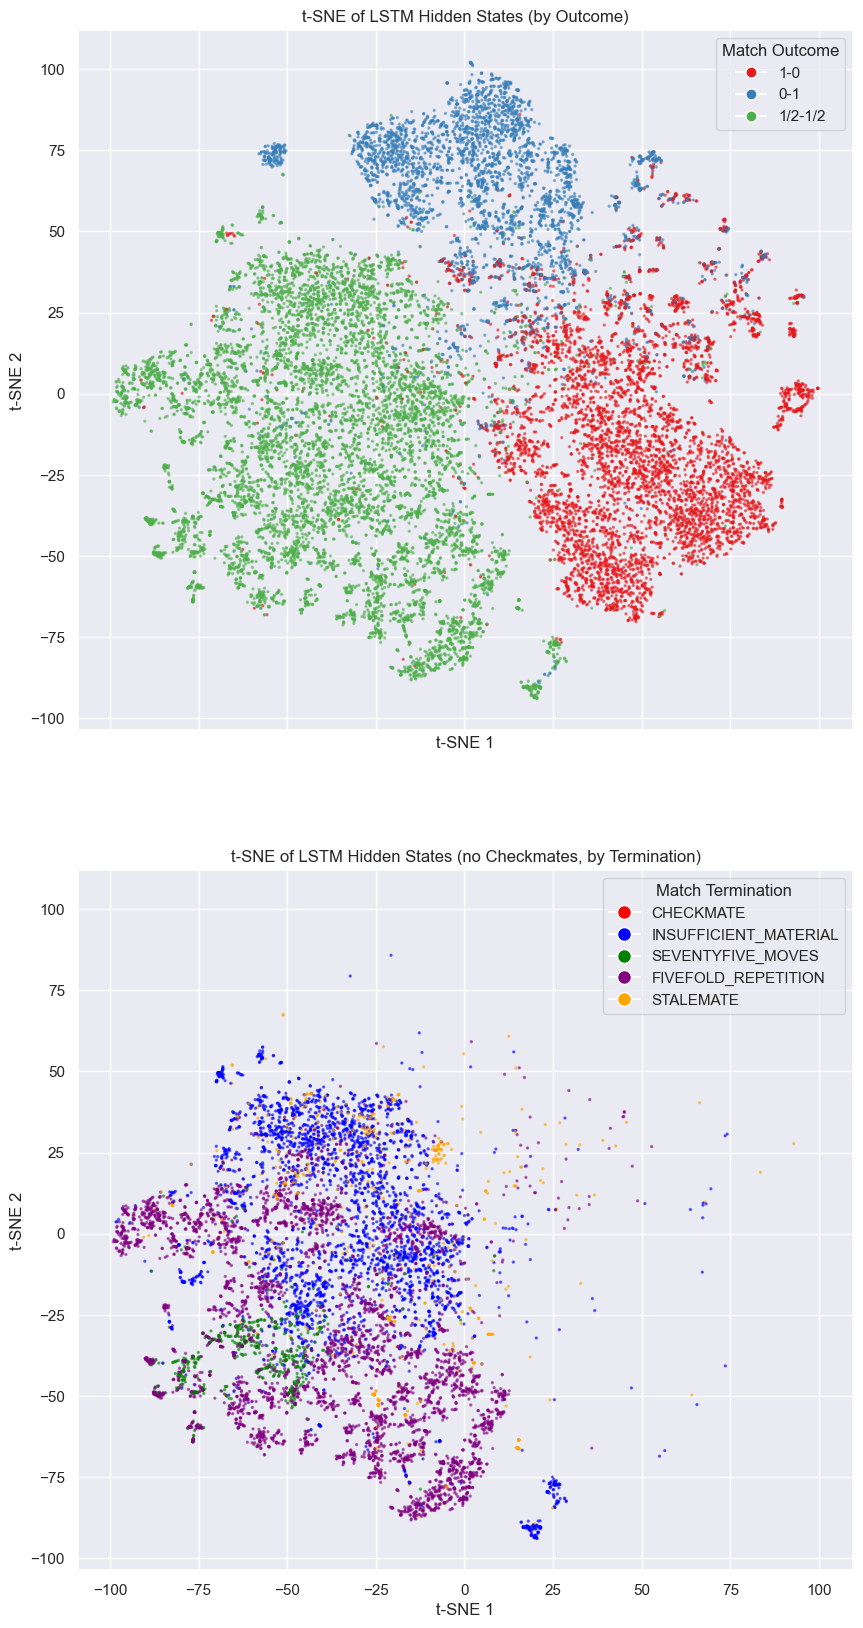

In [ ]:
# Plot the t-SNE
plt.figure(figsize=(10, 10))
fig, axes = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)
axes[0].scatter(cs_sampled_tsne[:, 0], cs_sampled_tsne[:, 1], alpha=0.5, s=2, c=matchOutcomesColors)
axes[0].legend(handles=legend_elements, title="Match Outcome")
axes[0].set_title("t-SNE of LSTM Hidden States (by Outcome)")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

cs_sampled_tsne_noCheckmates = cs_sampled_tsne[matchTerminationsLabels != 'CHECKMATE']
matchTerminationColors_noCheckmates = matchTerminationColors[matchTerminationsLabels != 'CHECKMATE']
axes[1].scatter(cs_sampled_tsne_noCheckmates[:, 0], cs_sampled_tsne_noCheckmates[:, 1], alpha=0.5, s=2, c=matchTerminationColors_noCheckmates)
axes[1].legend(handles=legendElementTermination, title="Match Termination")
axes[1].set_title("t-SNE of LSTM Hidden States (no Checkmates, by Termination)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")
plt.show()

In [ ]:
#Perform umap
import umap
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine', verbose=1)
cs_sampled_umap = umap_model.fit_transform(lstmEmbeddings)
cs_sampled_umap.shape

c:\Polimi\Master\2Sem\NLP-Project\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP(angular_rp_forest=True, metric='cosine', verbose=1)
Sun May 25 13:16:26 2025 Construct fuzzy simplicial set
Sun May 25 13:16:26 2025 Finding Nearest Neighbors
Sun May 25 13:16:26 2025 Building RP forest with 12 trees
Sun May 25 13:16:35 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Sun May 25 13:16:49 2025 Finished Nearest Neighbor Search
Sun May 25 13:16:52 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun May 25 13:16:58 2025 Finished embedding


(19999, 2)

<Figure size 1000x1000 with 0 Axes>

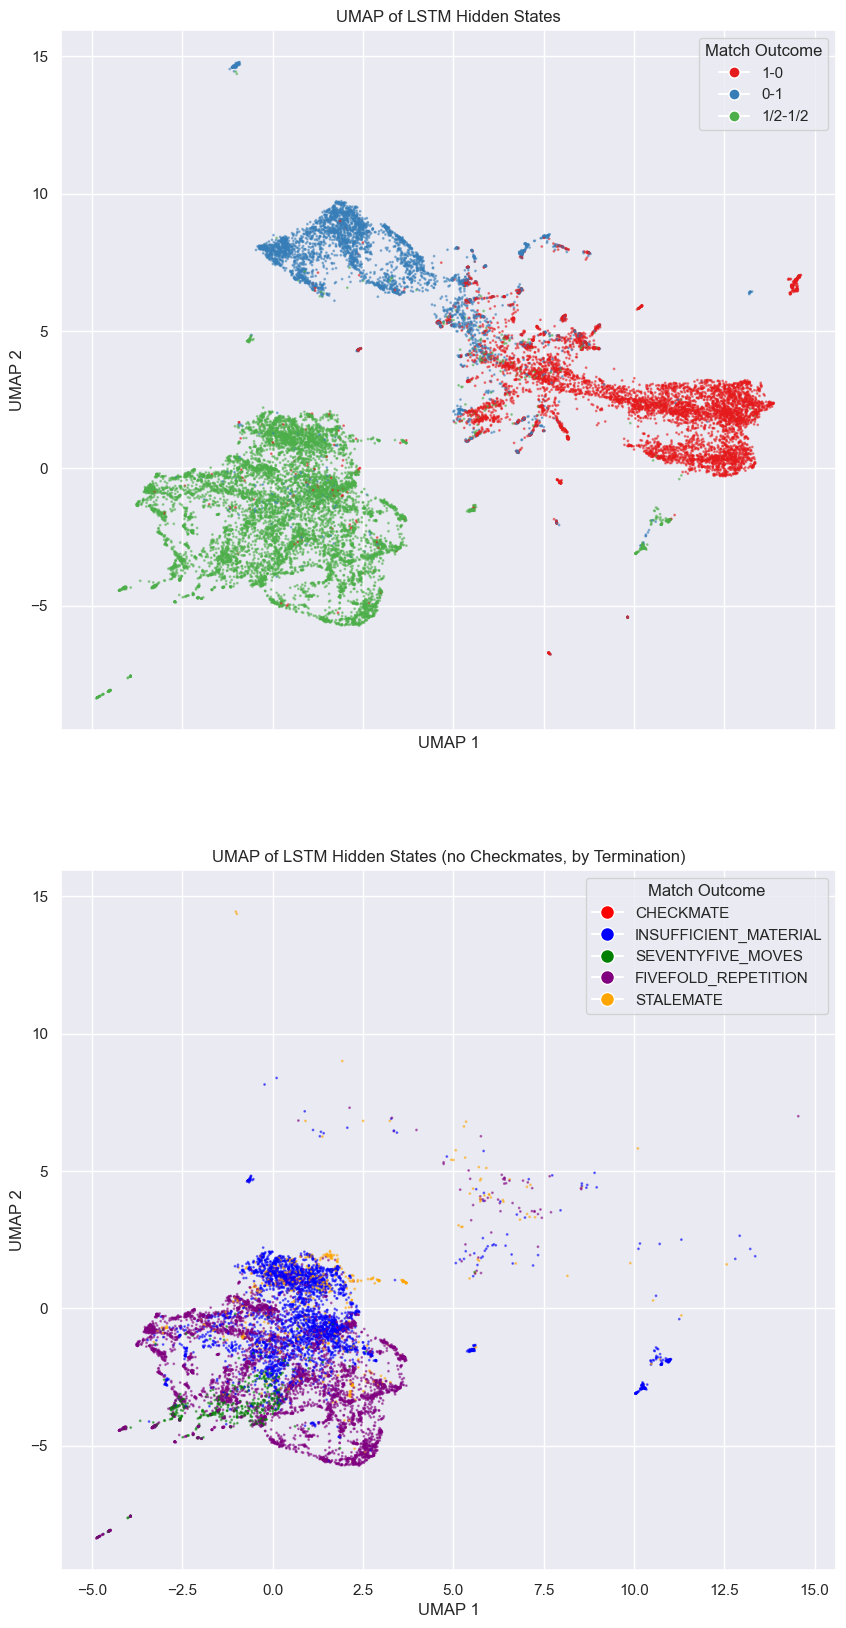

In [ ]:
# Plot the UMAP
plt.figure(figsize=(10, 10))
fig, axes = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)
axes[0].scatter(cs_sampled_umap[:, 0], cs_sampled_umap[:, 1], alpha=0.5, s=1, c=matchOutcomesColors)
axes[0].legend(handles=legend_elements, title="Match Outcome")
axes[0].set_title("UMAP of LSTM Hidden States")
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")

cs_sampled_umap_noCheckmates = cs_sampled_umap[matchTerminationsLabels != 'CHECKMATE']
matchTerminationColors_noCheckmates = matchTerminationColors[matchTerminationsLabels != 'CHECKMATE']
axes[1].scatter(cs_sampled_umap_noCheckmates[:, 0], cs_sampled_umap_noCheckmates[:, 1], alpha=0.5, s=1, c=matchTerminationColors_noCheckmates)
axes[1].legend(handles=legendElementTermination, title="Match Outcome")
axes[1].set_title("UMAP of LSTM Hidden States (no Checkmates, by Termination)")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")
plt.show()


# RAG

In [ ]:
def topClosestTo(game, n=10):
    """
    Find the top n closest games to the given game based on the UMAP embedding.
    """
    # Move the tensor to the same device as the model
    fame = game.to(model.device)

    # Get the model output
    with torch.no_grad():
        output, (h, c) = model(game)

    # Get the last hidden state
    game_embedding = c.squeeze().cpu()
    cs_embeddings = lstmEmbeddings
    # Compute distances in parallel using torch
    # Normalize embeddings for cosine distance
    game_embedding_norm = game_embedding[0] / game_embedding[0].norm()
    cs_embeddings_norm = cs_embeddings / cs_embeddings.norm(dim=1, keepdim=True)
    similarity = torch.matmul(cs_embeddings_norm, game_embedding_norm)
    closest_indices = torch.topk(similarity, n).indices.cpu().numpy()
    return closest_indices, similarity[closest_indices].cpu().numpy()

topClosestTo(dataset[0][0][0])

(array([   0, 4383, 9067, 5999, 8844, 9997, 4147, 8312, 9711, 2254],
       dtype=int64),
 array([0.99999994, 0.9731257 , 0.9726935 , 0.9726355 , 0.97180915,
        0.969946  , 0.9695353 , 0.9693592 , 0.9686277 , 0.9686277 ],
       dtype=float32))

Game 1
	Similarity: 0.9999999403953552
	Length: 163 moves
	Outcome: 1-0
--------------------------------------------------
Game 2
	Similarity: 0.973125696182251
	Length: 161 moves
	Outcome: 1-0
--------------------------------------------------
Game 3
	Similarity: 0.9726935029029846
	Length: 200 moves
	Outcome: 1/2-1/2
--------------------------------------------------
Game 4
	Similarity: 0.9726355075836182
	Length: 351 moves
	Outcome: 1-0
--------------------------------------------------
Game 5
	Similarity: 0.9718091487884521
	Length: 89 moves
	Outcome: 1-0
--------------------------------------------------
Game 6
	Similarity: 0.969946026802063
	Length: 93 moves
	Outcome: 1/2-1/2
--------------------------------------------------
Game 7
	Similarity: 0.9695352911949158
	Length: 147 moves
	Outcome: 1-0
--------------------------------------------------
Game 8
	Similarity: 0.9693592190742493
	Length: 364 moves
	Outcome: 1/2-1/2
--------------------------------------------------
Game 9
	

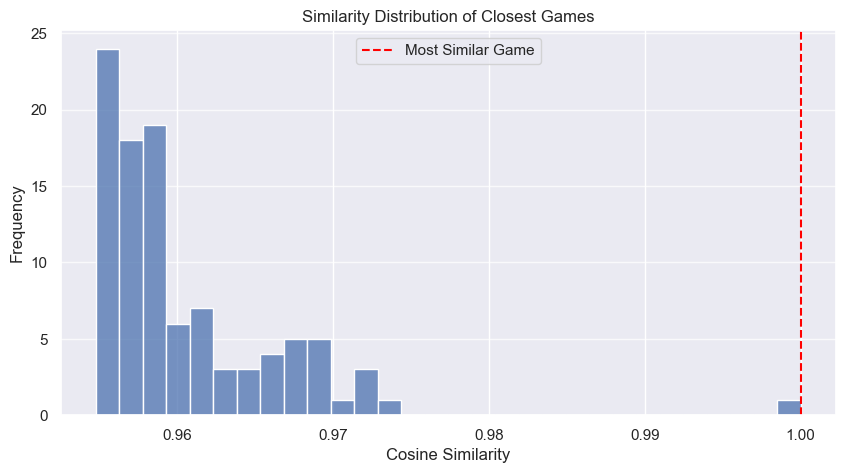

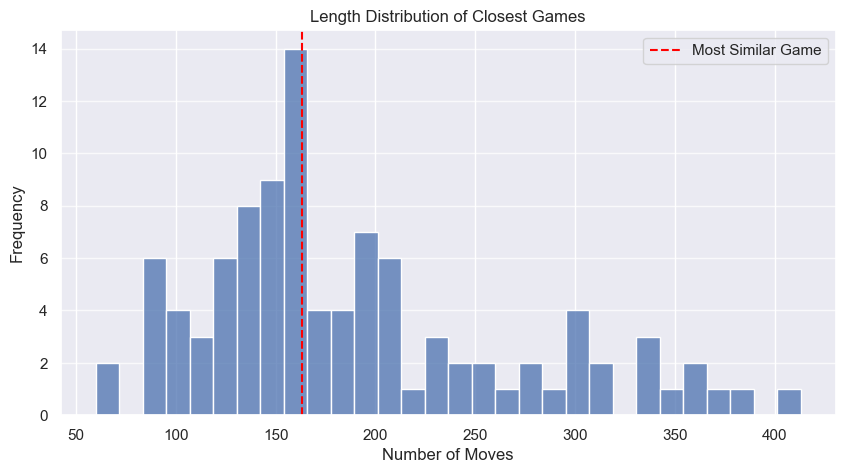

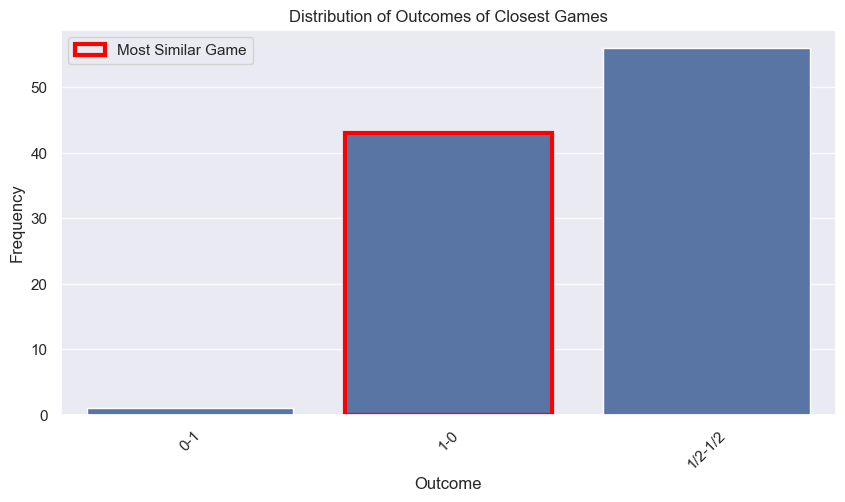

In [ ]:
from matplotlib.patches import Patch

closest_indices, similarity = topClosestTo(dataset[0][0][0], n=100)

closest_games = [dataset[i][0][0] for i in closest_indices]
lengths = [len(game) for game in closest_games]
similarityOutcomes = matchOutcomesLabels[closest_indices]
for i, game in enumerate(closest_games):
    print(f"Game {i+1}")
    print(f"\tSimilarity: {similarity[i]}")
    print(f"\tLength: {len(game)} moves")
    print(f"\tOutcome: {similarityOutcomes[i]}")
    print("-" * 50)

# Plot the similarity distribution and mark the most similar game
plt.figure(figsize=(10, 5))
sns.histplot(similarity, bins=30)
plt.axvline(similarity[0], color='red', linestyle='--', label='Most Similar Game')
plt.title("Similarity Distribution of Closest Games")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

# Plot the length distribution of the closest games and mark the most similar game
plt.figure(figsize=(10, 5))
sns.histplot(lengths, bins=30)
plt.axvline(lengths[0], color='red', linestyle='--', label='Most Similar Game')
plt.title("Length Distribution of Closest Games")
plt.xlabel("Number of Moves")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

# Plot the distribution of outcomes of the closest games and mark the most similar game
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=similarityOutcomes, order=np.unique(similarityOutcomes))
# Mark the outcome of the most similar game
most_similar_outcome = similarityOutcomes[0]
unique_outcomes = np.unique(similarityOutcomes)
most_similar_idx = np.where(unique_outcomes == most_similar_outcome)[0][0]
for i, p in enumerate(ax.patches):
    if i == most_similar_idx:
        p.set_edgecolor('red')
        p.set_linewidth(3)
# Add legend for the most similar game
legend_elements = [Patch(facecolor='none', edgecolor='red', linewidth=3, label='Most Similar Game')]
plt.title("Distribution of Outcomes of Closest Games")
plt.xlabel("Outcome")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.legend(handles=legend_elements)
plt.show()